# 2: LSTM for Text Classification

<br>

**February 2nd and 3rd**

We will build an LSTM model to classify movie reviews as either positive or negative. After training, we will extract the word embeddings learned by the model.

### **1. Getting the Dataset**

We will be using the imdb dataset. This is a dataset of 25,000 movie reviews from IMDB, labeled by sentiment - positive (1) or negative (0). 
<br>

The reviews have been preprocessed, and each review is encoded as a list of word indices. In this preprocessed corpus, the words are indexed by overall frequency in the dataset, such that a word with index 3 occurs more frequently than a word with index 10.
<br>

In the following blocks of code in this section, we will load and visualize the data.


In [1]:
from tensorflow.keras import datasets
imdb = datasets.imdb

In [2]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, 
                                                                   index_from=OFFSET)

In [3]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [4]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 

Keras provides a way to do this.  In this section, we will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.



In [5]:
from keras.preprocessing.sequence import pad_sequences


MAX_LENGHT = 500

padded_train_data = pad_sequences(train_data, maxlen = MAX_LENGHT)
padded_test_data = pad_sequences(test_data, maxlen = MAX_LENGHT)

In [6]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, we will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer 
*   The second step is to add an embedding layer like we did last week. This embedding layer creates a lookup table of the form {word:embedding} for each of the unique words in our corpus. Use EMBED_SIZE = 100 (i.e each word is represented by a 100D vector such that each movie review is 500 X 100 in dimension.  Don't forget to set mask_zero=True since we are using 0 index as out padding.
*  The third step is to add an LSTM with 100 units. By leaving 'return_sequences' as False, the output of this model will be the output of the final time step of the LSTM. https://keras.io/api/layers/recurrent_layers/lstm/ 
*  The final layer of the model is a fully connected (Dense) layer.
*  The model should be compiled with a 'binary_crossentropy' loss function, an 'adam' optimizer. We also want to visualize the model accuracy during training so the 'metrics' parameter of the compile method should be set to ['accuracy'].

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model

EMBED_SIZE = 100

# 1. tell the model what sort of input to expect using the keras <Input> layer
input_layer = Input((MAX_LENGHT, ), dtype='int32')

# 2. add an embedding layer to creates a lookup table
embedding_layer = Embedding(input_dim = VOCAB_SIZE, 
                            input_length = MAX_LENGHT,
                            output_dim = EMBED_SIZE,
                            name='embedding',
                            mask_zero=True)(input_layer)


# 3. add an LSTM with 100 units
lstm_layer = LSTM(100, return_sequences = False)(embedding_layer)

# 4. add a final layer
label = Dense(1, activation = 'sigmoid')(lstm_layer)

# 5. compile the model with a 'binary_crossentropy' loss function, an 'adam' optimizer, 
# and 'accuracy' for 'metrics' parameter
model = Model(inputs = input_layer, outputs = label) 

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


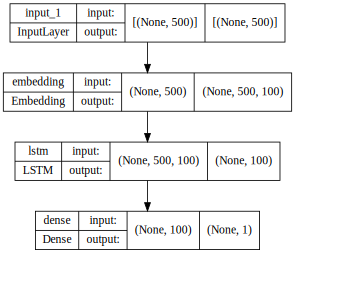

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, 
                           show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


### **4. Training the Model**

A model can memorize the training data (this is called 'overfitting' and when it does so, it's training accuracy can continue to go up but it's accuracy on previously unseen (i.e. non-training) examples can be very poor. To ensure that this doesn't happen, researchers often intermittently check the performance of a model being trained on a held back dataset called the ***validation dataset***. This way, 'early stopping' or 'random search' can be used to select the model that will generalize best to unseen data. 
<br>


In this lab, we will just plot training accuracy against validation accuracy to monitor the progress of our model. And, using the plot, we will theorize about what the optimal stopping point for our model should have been.


**Step 1: Getting a validation dataset**

Before we begin training, we will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [7]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [ ]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 253s 11s/step - loss: 0.6428 - accuracy: 0.6202 - val_loss: 0.5070 - val_accuracy: 0.8025
Epoch 2/6
23/23 [==============================] - 242s 11s/step - loss: 0.4010 - accuracy: 0.8448 - val_loss: 0.3253 - val_accuracy: 0.8780
Epoch 3/6
23/23 [==============================] - 240s 10s/step - loss: 0.2565 - accuracy: 0.9041 - val_loss: 0.2715 - val_accuracy: 0.8950
Epoch 4/6
23/23 [==============================] - 257s 11s/step - loss: 0.1968 - accuracy: 0.9314 - val_loss: 0.2808 - val_accuracy: 0.8925
Epoch 5/6
23/23 [==============================] - 249s 11s/step - loss: 0.1636 - accuracy: 0.9454 - val_loss: 0.2788 - val_accuracy: 0.8845
Epoch 6/6
23/23 [==============================] - 287s 13s/step - loss: 0.1593 - accuracy: 0.9469 - val_loss: 0.2869 - val_accuracy: 0.8865


**Step 3: Visualize the model plot**

In [8]:
!pip install plot_keras_history
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=63af64cb8fbc477f00262db189e122f0fd756698e6727babe76554cc8f725c6f
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=1a37e73e176ecf86aafc4ca447c48aa29c236a29d2a37cc58405071890731daa
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=f34d1c96cd48fe898538f4f5cc16db87bdc1ce4fd8a2255188cfd81b7a9617e9
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


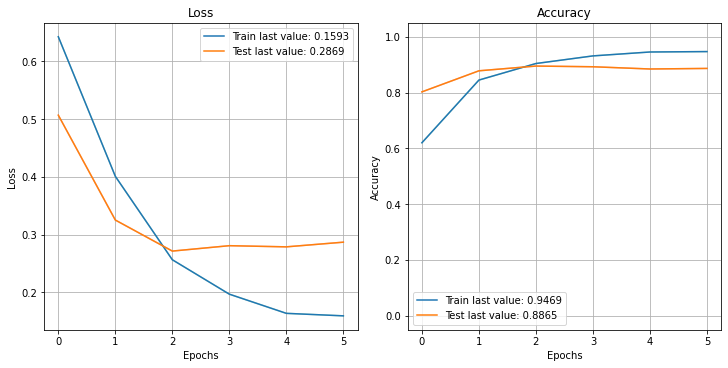

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [ ]:
results = model.evaluate(x = padded_test_data, 
                         y = test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

782/782 [==============================] - 136s 171ms/step - loss: 0.3242 - accuracy: 0.8670
test_loss: 0.3241529166698456 test_accuracy: 0.8669999837875366


### **6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model like we did in the last lab. 

In [ ]:
word_embeddings = model.get_layer('embedding').get_weights()[0] 

In [ ]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


### **7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset. 

As mentioned before, Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if we exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [ ]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2


**Step 2: Create a the idx2word dictionary**

In [ ]:
idx2word = {i: j for j, i in word2idx.items()}


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [ ]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

### **8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [ ]:
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2         3         4         5   \
woods     -0.004368 -0.048093  0.009366 -0.031701 -0.009465  0.003021   
hanging   -0.032570  0.034611  0.003373  0.036411 -0.033047  0.015757   
woody     -0.006985  0.045837  0.023310  0.004662 -0.012292 -0.006264   
arranged   0.003316 -0.009876  0.026397 -0.022256 -0.015373  0.045273   
bringing   0.034442 -0.040274 -0.009401 -0.048930  0.024369  0.028175   
wooden    -0.023558  0.023463 -0.015473  0.045108  0.008345  0.030677   
errors     0.043437 -0.041581 -0.029348  0.041709  0.008266 -0.037032   
dialogs   -0.028467 -0.013447 -0.012087  0.004836  0.020826 -0.030690   
kids       0.014200  0.041071  0.020423 -0.006575 -0.019336  0.056086   
uplifting  0.044608  0.030197  0.037298 -0.017023 -0.008218 -0.048065   

                 6         7         8         9   ...        90        91  \
woods     -0.022618  0.048549  0.000845 -0.037577  ...  0.013311  0.032521   
hanging    0.018704 -0.003657  0.033856 

### **9. Plot our Word Embeddings using t-SNE**


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


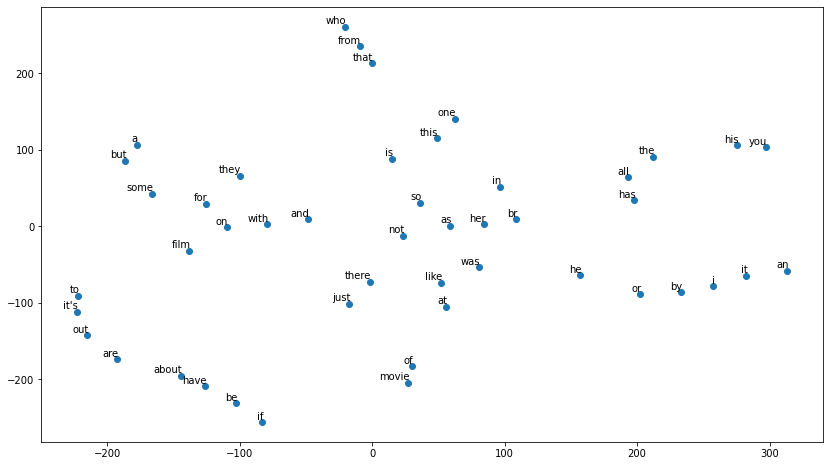

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        

